<a href="https://colab.research.google.com/github/Betul9/pantograph/blob/main/pantograph_object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#RUN 1
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import torch
from PIL import Image

import pandas as pd
from xml.dom import minidom
import csv

In [31]:
fileList = glob.glob('/content/drive/MyDrive/model_ep*.pth')
for file in fileList:
  os.remove(file)

In [34]:
os.chdir(r'/content/drive/MyDrive/DATASET/labels')
myFiles = glob.glob('*.txt')

myImageFiles = [w.replace('txt', 'jpg') for w in myFiles]

In [35]:
pip install pybboxes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import pybboxes as pbx
width=256
height=256
final_df=[]
for item, myname in zip(myFiles, myImageFiles):
    row=[]
    bbox_temp=[]
    with open(item, 'rt') as fd:
        first_line = fd.readline()
        splited = first_line.split();
        
        row.append(myname)
        row.append(width)
        row.append(height)

        #format değişimi
        row.append(float(splited[0]))
        yoloboxes = (float(splited[1]), float(splited[2]), float(splited[3]), float(splited[4]))
        newboxes = pbx.convert_bbox(yoloboxes, from_type="yolo", to_type="voc", image_size=(256,256))

        row.append(newboxes[0])
        row.append(newboxes[1])
        row.append(newboxes[2])
        row.append(newboxes[3])
        final_df.append(row)

df = pd.DataFrame(final_df,columns=['filename', 'width', 'height','class_num','xmin','ymin','xmax','ymax'])
os.chdir(r'/content/drive/MyDrive')
df.to_csv("/content/drive/MyDrive/DATASET/saved3.csv",index=False)

In [37]:
def preprocess_dataset():
  labels = []
  boxes = []
  img_list = []

  image_dir = '/content/drive/MyDrive/DATASET/images'

  with open('/content/drive/MyDrive/DATASET/saved3.csv') as csvfile:
      rows = csv.reader(csvfile)
      columns = next(iter(rows))
      for row in rows:
        labels.append(float(row[3]))
        arr = [float(row[4])/256,  
               float(row[5])/256,
               float(row[6])/256,
               float(row[7])/256]
        
        boxes.append(arr)
        img_path = row[0]
        img  = cv2.imread(os.path.join(image_dir,img_path))

        image = cv2.resize(img,(256,256))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = image.astype("float") / 255.0

        img_list.append(image)
 
  return labels, boxes, img_list

In [38]:
image_size = 256
labels, boxes, img_list = preprocess_dataset()

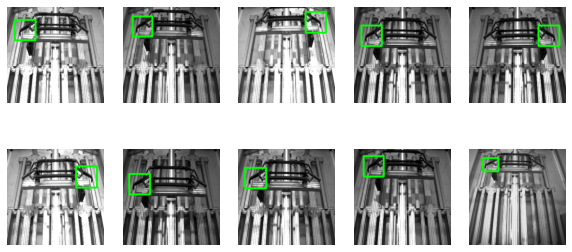

In [39]:
plt.figure(figsize=(10,10));

random_range = random.sample(range(1, len(img_list)), 10)

for itr, i in enumerate(random_range, 1):

    a1, b1, a2, b2 = boxes[i];
    img_size = 256

    x1 = a1 * img_size
    x2 = a2 * img_size
    y1 = b1 * img_size
    y2 = b2 * img_size

    image = img_list[i]

    cv2.rectangle(image, (int(x1),int(y1)),
          (int(x2),int(y2)),
                  (0,255,0),
                  3);
    
    img = np.clip(img_list[i], 0, 1)
    plt.subplot(4, 5, itr);
    plt.imshow(img);
    plt.axis('off');

In [40]:
train_images, val_images, train_labels, \
val_labels, train_boxes, val_boxes = train_test_split( np.array(img_list), 
                np.array(labels), np.array(boxes), test_size = 0.2, 
                random_state = 43)

print('Training Images Count: {}, Validation Images Count: {}'.format(
    len(train_images), len(val_images) ))

Training Images Count: 308, Validation Images Count: 78


In [41]:
#RUN 2
from PIL import Image
import torch
from torchvision import ops
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tensorflow as tf

import os
import pickle
import random
import time

In [42]:
#RUN 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [43]:
class Dataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.permute(torch.from_numpy(train_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()
        print(self.boxes)
    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])


class ValDataset(Dataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.permute(torch.from_numpy(val_images),(0,3,1,2)).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [44]:
dataset = Dataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

tensor([[0.0742, 0.2227, 0.2812, 0.4336],
        [0.1055, 0.0234, 0.3125, 0.2305],
        [0.0898, 0.1055, 0.3008, 0.3203],
        ...,
        [0.6914, 0.0547, 0.8945, 0.2656],
        [0.7344, 0.3438, 0.9531, 0.5625],
        [0.7266, 0.2930, 0.9570, 0.5117]])


In [45]:
#RUN 4
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=192, kernel_size=5)


        self.class_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.class_fc2 = nn.Linear(in_features=240, out_features=120)
        self.class_out = nn.Linear(in_features=120, out_features=1)

        self.box_fc1 = nn.Linear(in_features=1728, out_features=240)
        self.box_fc2 = nn.Linear(in_features=240, out_features=120)
        self.box_out = nn.Linear(in_features=120, out_features=4)


    def forward(self, t):
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv3(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv4(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = self.conv5(t)
        t = F.relu(t)
        t = F.avg_pool2d(t, kernel_size=4, stride=2)

        t = torch.flatten(t,start_dim=1)
        

        class_t = self.class_fc1(t)
        class_t = F.relu(class_t)

        class_t = self.class_fc2(class_t)
        class_t = F.relu(class_t)

        class_t = F.softmax(self.class_out(class_t),dim=1)

        box_t = self.box_fc1(t)
        box_t = F.relu(box_t)

        box_t = self.box_fc2(box_t)
        box_t = F.relu(box_t)

        box_t = self.box_out(box_t)
        box_t = F.sigmoid(box_t)

        return [class_t,box_t]

In [46]:
#RUN 5
model = Network()
model = model.to(device)

In [47]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [48]:
dataloader = torch.utils.data.DataLoader(
       dataset, batch_size=8, shuffle=True)
valdataloader = torch.utils.data.DataLoader(
       valdataset, batch_size=8, shuffle=True)

In [49]:
def train(model):
    optimizer = optim.SGD(model.parameters(),lr = 0.1)
    num_of_epochs = 100
    epochs = []
    losses = []
    total_iou =0
    os.mkdir('/content/drive/MyDrive/DATASET/models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (x, y, z) in enumerate(dataloader):
            x,y,z = x.to(device),y.to(device),z.to(device)
            optimizer.zero_grad()
            [y_pred,z_pred]= model(x)
            class_loss = F.cross_entropy(y_pred, y)
            box_loss = F.mse_loss(z_pred, z)
            box_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')

        model.eval()
        for batch, (x, y,z) in enumerate(valdataloader):
            x,y,z = x.to(device),y.to(device),z.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                [y_pred,z_pred]= model(x)
                
                class_loss = F.cross_entropy(y_pred, y)
                box_loss = F.mse_loss(z_pred, z)

                iou = ops.box_iou(z,z_pred)
                total_iou = iou.cpu().data.numpy()[0][0]

            tot_loss += box_loss.item()
            tot_correct += get_num_correct(y_pred, y)
            print("Test batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "IOU", total_iou, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
    torch.save(model.state_dict(), "/content/drive/MyDrive/DATASET/models/model_ep"+str(epoch+1)+".pth")

In [50]:
import shutil

shutil.rmtree('/content/drive/MyDrive/DATASET/models')

# import os

# directory = "/content/drive/MyDrive"
# test = os.listdir(directory)

# for item in test:
#     if item.endswith(".pth"):
#         os.remove( os.path.join( directory, item ) )


In [51]:
train(model)

Epoch 0 IOU 0.0 loss: 0.7822473868727684  time:  0.010478770732879639  mins
Epoch 1 IOU 0.0 loss: 0.7099648080766201  time:  0.009334687391916912  mins
Epoch 2 IOU 0.0 loss: 0.6549397148191929  time:  0.009102996190388997  mins
Epoch 3 IOU 0.0 loss: 0.6155415512621403  time:  0.008839241663614909  mins
Epoch 4 IOU 0.0 loss: 0.587838664650917  time:  0.009308234850565592  mins
Epoch 5 IOU 0.0 loss: 0.5682226307690144  time:  0.008824145793914795  mins
Epoch 6 IOU 0.0 loss: 0.5577043369412422  time:  0.009518524010976156  mins
Epoch 7 IOU 0.0 loss: 0.5421445891261101  time:  0.009613263607025146  mins
Epoch 8 IOU 0.0 loss: 0.5336400270462036  time:  0.00932154655456543  mins
Epoch 9 IOU 0.0 loss: 0.5277757607400417  time:  0.009200294812520346  mins
Epoch 10 IOU 0.06812538 loss: 0.526498518884182  time:  0.009172741572062175  mins
Epoch 11 IOU 0.0 loss: 0.5269066467881203  time:  0.009096976121266682  mins
Epoch 12 IOU 0.0 loss: 0.5247467420995235  time:  0.009010636806488037  mins
Epoch

In [ ]:
#RUN 6
def preprocess(img, image_size = 256):
    
    image = cv2.resize(img, (image_size, image_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float") / 255.0 

    image = np.expand_dims(image, axis=0) 
    return image

In [ ]:
#RUN 7
def postprocess(image, results):

    [class_probs, bounding_box] = results


    class_index = torch.argmax(class_probs)
  
    class_label = 0


    h, w = 800,800

    x1, y1, x2, y2 = bounding_box[0]

    x1 = int(w * x1)
    x2 = int(w * x2)
    y1 = int(h * y1)
    y2 = int(h * y2)

    return class_label, (x1,y1,x2,y2),torch.max(class_probs)*100

In [ ]:
#RUN 8
def predict(image,  scale = 0.5):
  model = Network()
  model = model.to(device)
  model.load_state_dict(torch.load("/content/drive/MyDrive/DATASET/models/model_ep100.pth"))
  model.eval()
  
  img  = cv2.imread(image)
  
  processed_image = preprocess(img)

  result = model(torch.permute(torch.from_numpy(processed_image).float(),(0,3,1,2)).to(device))

  label, (x1, y1, x2, y2), confidence = postprocess(image, result)

  cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 100), 2)
  cv2.putText(
      img, 
      '{}, CONFIDENCE: {}'.format(label, confidence), 
      (30, int(35 * scale)), 
      cv2.FONT_HERSHEY_COMPLEX, scale,
      (200, 55, 100),
      2
      )

  plt.figure(figsize=(10,10))
  plt.imshow(img[:,:,::-1])

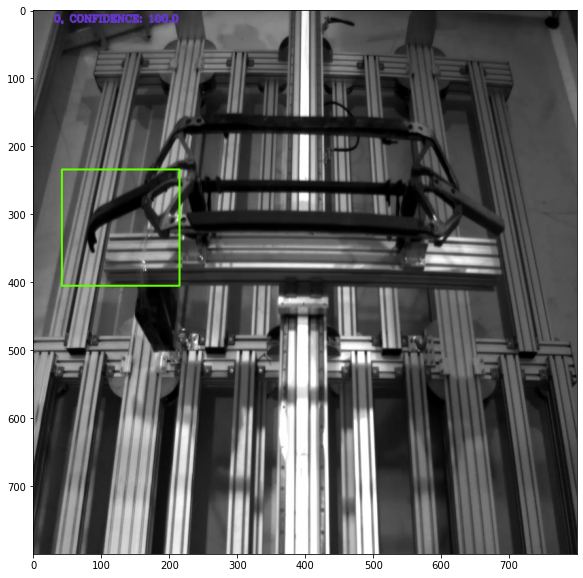

In [ ]:
#RUN 9
image = '/content/drive/MyDrive/augmented_dataset/images/frame114.jpg'

predict(image)